In [42]:
# Import necessary libraries
import os
import glob


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold

import numpy as np
import matplotlib.pyplot as plt

# import my tools 
import my_tools

In [13]:
# import the dataset
ham_path = 'enron1/ham/'
spam_path = 'enron1/spam/'

In [14]:
# Read the dataset
emails, labels = [], []

for filename in glob.glob(os.path.join(ham_path, '*.txt')):
    with open(filename, 'r', encoding = "ISO-8859-1") as infile:
        emails.append(infile.read())
        labels.append(0)

for filename in glob.glob(os.path.join(spam_path, '*.txt')):
    with open(filename, 'r', encoding = "ISO-8859-1") as infile:
        emails.append(infile.read())
        labels.append(1)


In [15]:
# Preprocess and clean the raw text data.
cleaned_emails = my_tools.clean_text(emails)

In [16]:
# Remove stop words
cv = CountVectorizer(stop_words="english", max_features=500)

# split dataset in train and test
X_train, X_test, Y_train, Y_test = train_test_split(cleaned_emails, labels, test_size=0.33, random_state=42)

In [17]:
# Build model
label_index = my_tools.get_label_index(labels)
prior = my_tools.get_prior(label_index)
smoothing = 1

In [18]:
# Each row is a term frequency sparse vector for a document and email.
term_docs_train = cv.fit_transform(X_train)
label_index = my_tools.get_label_index(Y_train)
prior = my_tools.get_prior(label_index)
likelihood = my_tools.get_likelihood(term_docs_train, label_index, smoothing)

# Predict the posterior of the testing/new dataset
term_docs_test = cv.transform(X_test)
posterior = my_tools.get_posterior(term_docs_test, prior, likelihood)

In [19]:
# evaluate the model performance
correct = 0.0
for pred, actual in zip(posterior, Y_test):
    if actual == 1:
        if pred[1] >= 0.5:
            correct += 1
    elif pred[0] > 0.5:
        correct += 1

print('The accuracy on {0} testing samples is:{1:.1f}%'.format(
    len(Y_test), correct/len(Y_test) * 100 )
)


The accuracy on 1707 testing samples is:90.4%


In [9]:
# Test code  DO NOT RUN THIS CELL!
emails_test = [
    "Hello dear, i hope you are allright",
    "Do not forget our date at 5:00pm",
    "You have WON!!! Click and receive awards"
 ]

cleaned_test = my_tools.clean_text(emails_test)
term_docs_test = cv.transform(cleaned_test)
posterior = my_tools.get_posterior(term_docs_test, prior, likelihood)
print(posterior)

for num,item in enumerate(posterior):
    if item[0] > item[1]:
        print(f'Email {num+1}: is legit email')
    elif item[0] < item[1]:
        print(f'Email {num+1}: is spam')

[{0: 0.6888456236212768, 1: 0.31115437637872323}, {0: 0.7543059820837963, 1: 0.24569401791620366}, {0: 0.13791900131635174, 1: 0.8620809986836483}]
Email 1: is legit email
Email 2: is legit email
Email 3: is spam


## Spam detection using scikit learn

In [27]:
clf = MultinomialNB(alpha=1.0, fit_prior=True)

In [28]:
clf.fit(term_docs_train, Y_train)

MultinomialNB()

In [29]:
#obtain the prediction results with the predict_proba method:
prediction_prob = clf.predict_proba(term_docs_test)
prediction_prob[:10]

array([[1.00000000e+000, 6.40853994e-038],
       [9.99999996e-001, 4.03791754e-009],
       [7.05050505e-001, 2.94949495e-001],
       [9.98826504e-001, 1.17349633e-003],
       [1.00000000e+000, 7.90657891e-025],
       [1.00000000e+000, 1.04379830e-038],
       [1.00000000e+000, 1.79700713e-039],
       [1.17229798e-001, 8.82770202e-001],
       [1.00000000e+000, 1.27546445e-103],
       [1.00000000e+000, 4.92235841e-020]])

In [30]:
prediction = clf.predict(term_docs_test)
prediction[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [31]:
# measure the accuracy performanceby calling the score method
accuracy = clf.score(term_docs_test, Y_test)
print('The accuracy using MultinomialNB is:{0:.1f}%'.format(accuracy*100))

The accuracy using MultinomialNB is:91.0%


In [32]:
report = classification_report(Y_test, prediction)

In [33]:
print(report)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1229
           1       0.81      0.89      0.85       478

    accuracy                           0.91      1707
   macro avg       0.88      0.91      0.89      1707
weighted avg       0.91      0.91      0.91      1707



1) Precision
  > fraction of CORRECT positive calls : TP / (TP + FP)

2) Recall(true positive rate)
  > fraction of TP that are correctly identified:
       TP / (TP +FN)
       
3) F1 score: includes both the precision and the recall, and equates to their harmonic mean:
> F1 = 2* (precision*recall) / (precision+recall)

Sometimes a model has a higher average f1 score than another model, but 
a significantly low f1 score for a particular class; sometimes two 
models have the same average f1 scores, but one has a higher f1 score
for one class while a lower score for another class. In situations like 
these, how can we judge which model works better? **Area Under the Curve 
(AUC) of the Receiver Operating Characteristic (ROC) is a united
measurement frequently used in binary classification.**

>**ROC curve is a plot of the true positive rate versus the false positive rate at various
probability thresholds ranging from 0 to 1**, if the probability of the
positive class is greater than the threshold, the positive class is assigned, otherwise it is negative.


In [37]:
# exhibit the ROC code
pos_prob = prediction_prob[:,1]
thresholds = np.arange(0.0, 1.2, 0.1)
true_pos, false_pos = [0] * len(thresholds), [0] * len(thresholds)
for pred, y in zip(pos_prob, Y_test):
    for i,threshold in enumerate(thresholds):
        if pred >= threshold:
        # if true and predictrion are both 1
            if y == 1:
                true_pos[i] += 1
            # if truth is 0 while prediction is 1
            else:
                false_pos[i] += 1
        else:
            break

In [38]:
# calculate the true and false positive rates for all threshold
true_pos_rate = [tp/ 478.0 for tp in true_pos]
false_pos_rate = [fp / 1229.0 for fp in false_pos]

#### Plot ROC curve

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


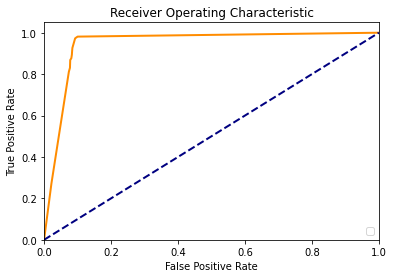

In [39]:
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0,1],[0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**The dash line** is the baseline representing random guessing here the true positive rate increases linearly with the false positive rate, and its AUC is 0.5.
**The orange line** is the ROC plot of our model, and its AUC is somewhat less than 1
>**In a perfect case**, the true positive samples have a probability 1, so that the ROC starts at the point with 100% true positive and 0 false positive. The AUC of such a perfect curve is 1. 
>>**To compute the exact AUC of our model, we can resort to the scikit-learn roc_auc_score function:**

In [43]:
#to divide the data into chunks with preserved class fractions we use the StratifiedKFold
k = 10
k_fold = StratifiedKFold(n_splits=k)
cleaned_emails_np = np.array(cleaned_emails)
labels_np = np.array(labels)
max_features_option = [2000, 4000, 8000]
smoothing_factor_option = [0.5, 1.0, 1.5, 2.0]
fit_prior_option = [True, False]
auc_record = {}

Then, for each fold generated by the split method of the k_fold object, repeat the process of term count feature extraction, classifier raining, and prediction with one of the aforementioned combinations of parameters, and record the resulting AUCs:

In [44]:
for train_indices, test_indices in k_fold.split(cleaned_emails, labels):
    X_train, X_test = cleaned_emails_np[train_indices], cleaned_emails_np[test_indices]
    Y_train, Y_test = labels_np[train_indices], labels_np[test_indices]
    for max_features in max_features_option:
        if max_features not in auc_record:
            auc_record[max_features] = {}
        cv = CountVectorizer(stop_words='english', max_features=max_features)
        term_docs_train = cv.fit_transform(X_train)
        term_docs_test = cv.transform(X_test)
        for smoothing in smoothing_factor_option:
            if smoothing not in auc_record[max_features]:
                auc_record[max_features][smoothing] = {}
            for fit_prior in fit_prior_option:
                clf = MultinomialNB(alpha=smoothing,
                                   fit_prior=fit_prior)
                clf.fit(term_docs_train, Y_train)
                prediction_prob = clf.predict_proba(term_docs_test)
                pos_prob = prediction_prob[:, 1]
                auc = roc_auc_score(Y_test, pos_prob)
                auc_record[max_features][smoothing][fit_prior] = auc + auc_record[max_features][smoothing].get(fit_prior, 0.0)
                

In [46]:
print('max features\t smoothing\t fit prior\t auc'.format(max_features, smoothing, fit_prior, auc/k))
for max_features, max_feature_record in auc_record.items():
    for smoothing, smoothing_record in max_feature_record.items():
        for fit_prior, auc in smoothing_record.items():
            print('{0}\t\t {1}\t\t {2}\t\t {3:.4f}'.format(max_features, smoothing, fit_prior, auc/k))

max features	 smoothing	 fit prior	 auc
2000		 0.5		 True		 0.9774
2000		 0.5		 False		 0.9772
2000		 1.0		 True		 0.9757
2000		 1.0		 False		 0.9756
2000		 1.5		 True		 0.9745
2000		 1.5		 False		 0.9745
2000		 2.0		 True		 0.9737
2000		 2.0		 False		 0.9737
4000		 0.5		 True		 0.9843
4000		 0.5		 False		 0.9842
4000		 1.0		 True		 0.9828
4000		 1.0		 False		 0.9827
4000		 1.5		 True		 0.9819
4000		 1.5		 False		 0.9819
4000		 2.0		 True		 0.9812
4000		 2.0		 False		 0.9811
8000		 0.5		 True		 0.9882
8000		 0.5		 False		 0.9881
8000		 1.0		 True		 0.9870
8000		 1.0		 False		 0.9870
8000		 1.5		 True		 0.9865
8000		 1.5		 False		 0.9864
8000		 2.0		 True		 0.9863
8000		 2.0		 False		 0.9861
